# Transfer Learning for Computer Vision Tutorial
전이학습을 활용하여 CNN에 이미지 분류를 학습시켜보자.

충분한 크기의 데이터셋이 드물기에 CNN을 처음부터 훈련시키는 일은 일반적이지 않다. 보통은 ImageNet과 같은 큰 데이터셋으로 훈련시킨 ConvNet을 가져오고, 전이학습을 통해 모델을 완성한다. 일반적인 시나리오는 다음과 같다.

- Finetuning the ConvNet: 해당 ConvNet을 초기값으로 설정한 네트워크에서 학습을 시작한다.
- ConvNet as fixed feature extractor: 해당 ConvNet을 특징추출기로 활용한다. 그리고 마지막 FC만 학습시킨다.

두 시나리오를 모두 진행한다. 먼저 공통으로 사용하는 코드를 작성하자.

> Transfer learning과 finetuning의 차이는 무엇일까?

In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

cudnn.benchmark = True
plt.ion()   # interactive mode

## Load Data
개미와 벌을 분류하는 모델을 훈련시켜보자. 먼저 [데이터](https://download.pytorch.org/tutorial/hymenoptera_data.zip)를 다운로드한다(`./data/hymenoptera`). 각 카테고리는 ImageNet에서 추려온 120개 학습용 이미지와 75개 평가용 이미지로 구성된다. 굉장히 작은 데이터셋이지만 전이학습은 시도할 수 있다.

- `torchvision.datasets.ImageFolder`를 사용하여 커스텀 데이터셋을 손쉽게 구성했다. 복잡한 과정을 거쳤던 이전 튜토리얼과는 달리, 이미지 경로만 지정하는 수준이다.

In [3]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'data/hymenoptera'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4)
               for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x])
                 for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Visualize a few images
학습데이터를 열어보자.

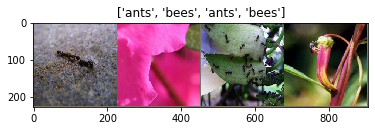

In [4]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

## Training the model
모델 학습을 위한 함수를 만들어보자.

1. 다음을 수 에포크 반복한다:
    1. 학습 페이즈에서,
        1. 예측하고 손실을 계산한다.
        2. 학습한다.
    2. 평가 페이즈에서,
        1. 예측하고 손실을 계산한다.
        2. 결과가 이전보다 좋다면 모델을 저장해둔다.
2. 최선의 모델을 반환한다.
    

In [6]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

### Visualizing the model predictions
모델의 예측결과를 시각화하는 함수를 만들어보자.

In [7]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
                
        model.train(mode=was_training)

## 선택 A. Finetuning the ConvNet
사전학습된 모델을 불러오고, 마지막 FC 레이어를 초기화한다.

1. 모델 `torchvision.models.resnet18`을 불러온다.
2. 해당 모델의 FC를 새로운 레이어 `nn.Linear`로 교체한다. 입력은 기존 레이어와 동일하며, 출력은 개미와 벌을 분류하므로 2로 설정한다.
3. 모델을 `device`에 연결한다.
4. 최적화 기법을 설정한다.
5. 에포크에 따라 학습률이 감소하도록 스케쥴러를 설정한다.

In [8]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)    # Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)         # Observe that all parameters are being optimized
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)    # Decay LR by a factor of 0.1 every 7 epochs

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/fini/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100.0%


### Train and evaluate
학습한다.

- 손실이 감소했다?: 0.2272 --> 0.2156
- 정확도가 높아졌다: 0.9085 --> 0.9216

> 손실은 진동했을 뿐 그대로인 것 같은데? 전이학습은 원래 이런가?

Epoch 0/24
----------
train Loss: 0.5378 Acc: 0.7336
val Loss: 0.2272 Acc: 0.9085

Epoch 1/24
----------
train Loss: 0.3874 Acc: 0.8238
val Loss: 0.2792 Acc: 0.9020

Epoch 2/24
----------
train Loss: 0.4559 Acc: 0.7869
val Loss: 0.5315 Acc: 0.8039

Epoch 3/24
----------
train Loss: 0.3859 Acc: 0.8443
val Loss: 0.3081 Acc: 0.8693

Epoch 4/24
----------
train Loss: 0.5317 Acc: 0.7869
val Loss: 0.2964 Acc: 0.9020

Epoch 5/24
----------
train Loss: 0.3806 Acc: 0.8730
val Loss: 0.2707 Acc: 0.9150

Epoch 6/24
----------
train Loss: 0.5531 Acc: 0.8156
val Loss: 0.2836 Acc: 0.8954

Epoch 7/24
----------
train Loss: 0.3928 Acc: 0.8443
val Loss: 0.2995 Acc: 0.8954

Epoch 8/24
----------
train Loss: 0.3577 Acc: 0.8607
val Loss: 0.2662 Acc: 0.9085

Epoch 9/24
----------
train Loss: 0.2851 Acc: 0.8689
val Loss: 0.2556 Acc: 0.8889

Epoch 10/24
----------
train Loss: 0.3401 Acc: 0.8607
val Loss: 0.2411 Acc: 0.8954

Epoch 11/24
----------
train Loss: 0.3199 Acc: 0.8689
val Loss: 0.2344 Acc: 0.9150

Ep

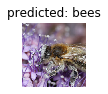

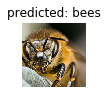

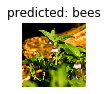

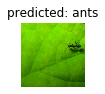

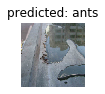

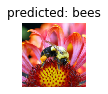

In [9]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)
visualize_model(model_ft)

## 선택 B. ConvNet as fixed feature extractor
기존 모델의 파라미터를 동결한다.

1. 모델 `torchvision.models.resnet18`을 불러온다. 파라미터의 기울기를 제거하는 방식으로 동결한다.
2. 해당 모델의 FC를 새로운 레이어 `nn.Linear`로 교체한다. 입력은 기존 레이어와 동일하며, 출력은 개미와 벌을 분류하므로 2로 설정한다.
3. 모델을 `device`에 연결한다.
4. 최적화 기법을 설정한다.
5. 에포크에 따라 학습률이 감소하도록 스케쥴러를 설정한다.

In [10]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)  # Parameters of newly constructed modules have requires_grad=True by default
model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)  # Decay LR by a factor of 0.1 every 7 epochs

### Train and evaluate
학습한다.

- 손실이 감소했다?: 0.2269 --> 0.1846
- 정확도가 높아졌다: 0.9085 --> 0.9477

> 선택 A보다 선택 B가 좋은 결과를 보였다. 선택 A가 모델 전체를 학습시키는 만큼 데이터셋이 충분치 않았다고 봐야 하나?

Epoch 0/24
----------
train Loss: 0.5590 Acc: 0.7254
val Loss: 0.2269 Acc: 0.9085

Epoch 1/24
----------
train Loss: 0.6069 Acc: 0.7541
val Loss: 0.1592 Acc: 0.9608

Epoch 2/24
----------
train Loss: 0.3906 Acc: 0.8279
val Loss: 0.1696 Acc: 0.9542

Epoch 3/24
----------
train Loss: 0.5038 Acc: 0.7910
val Loss: 0.3362 Acc: 0.8758

Epoch 4/24
----------
train Loss: 0.3967 Acc: 0.8156
val Loss: 0.2427 Acc: 0.9281

Epoch 5/24
----------
train Loss: 0.5824 Acc: 0.7664
val Loss: 0.1868 Acc: 0.9477

Epoch 6/24
----------
train Loss: 0.5956 Acc: 0.7500
val Loss: 0.1926 Acc: 0.9281

Epoch 7/24
----------
train Loss: 0.3651 Acc: 0.8443
val Loss: 0.2283 Acc: 0.9150

Epoch 8/24
----------
train Loss: 0.3859 Acc: 0.8279
val Loss: 0.1721 Acc: 0.9412

Epoch 9/24
----------
train Loss: 0.3161 Acc: 0.8689
val Loss: 0.1870 Acc: 0.9412

Epoch 10/24
----------
train Loss: 0.3483 Acc: 0.8402
val Loss: 0.1892 Acc: 0.9412

Epoch 11/24
----------
train Loss: 0.3193 Acc: 0.8730
val Loss: 0.1939 Acc: 0.9281

Ep

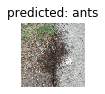

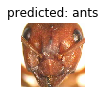

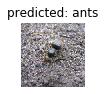

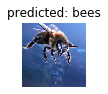

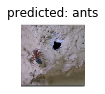

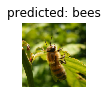

In [11]:
model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=25)
visualize_model(model_conv)

plt.ioff()
plt.show()

전이학습을 더 알고싶다면 [Quantized Transfer Learning for Computer Vision Tutorial](https://pytorch.org/tutorials/intermediate/quantized_transfer_learning_tutorial.html)을 읽어보자.